In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer
import kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/cityscapes-image-pairs")

print("Path to dataset files:", path)
os.listdir(path)

100%|██████████| 202M/202M [00:11<00:00, 18.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dansbecker/cityscapes-image-pairs/versions/1


['cityscapes_data']

In [4]:
train_path = os.path.join(path,'cityscapes_data',"train")
val_path  = os.path.join(path,'cityscapes_data',"val")

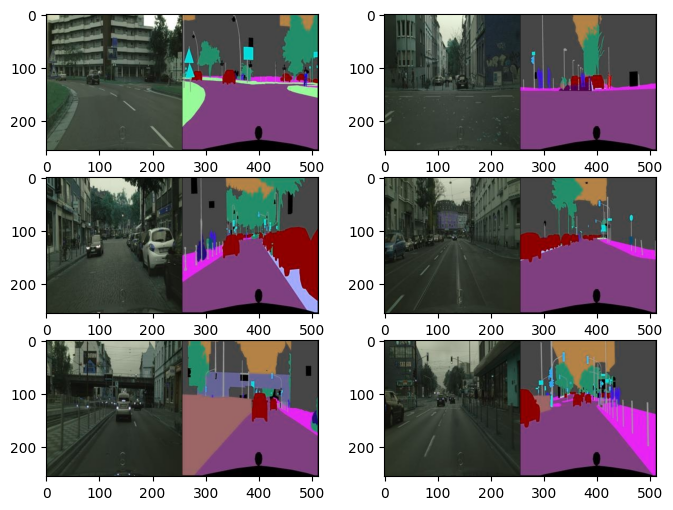

In [13]:
def show_sample(dir,num_images=6):
  plt.figure(figsize=(8,6))

  images = sorted(os.listdir(dir))

  for i in range(num_images):
    ax = plt.subplot(3,2,i+1)
    img = cv2.imread(os.path.join(dir,images[i]))
    plt.imshow(img)
  plt.show()
show_sample(train_path)


In [16]:
def preprocess_images(path: str):
    images = []
    masks = []
    directory = path
    for image in os.listdir(directory):
        img = cv2.imread(directory+image)
        img = cv2.resize(img, (128, 128))
        #Train
        cropped_image_train = img[0:64, 0:64]
        images.append(cropped_image_train)
        #Validation
        cropped_image_valid = img[0:64, 64:128]
        masks.append(cropped_image_valid)
    return images, masks

In [20]:
train_images,train_masks = preprocess_images(train_path+'/')
val_images,val_masks = preprocess_images(val_path+"/")

In [21]:
train_images = np.array(train_images,dtype="float32")/255.0
train_masks = np.array(train_masks,dtype="float32")/255.0
val_images = np.array(val_images,dtype="float32")/255.0
val_masks = np.array(val_masks,dtype="float32")/255.0

In [22]:
def ConvBlock(x, n_filters):
    # Taking first input and implementing the first conv block
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    return x

In [23]:
def downsample_block(x, n_filters):
    f = ConvBlock(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p



In [24]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = ConvBlock(x, n_filters)
    return x

In [25]:
def build_unet_model(output_channels):
    # input layer
    inputs = layers.Input(shape=(64, 64, 3))

    # encoder - downsample
    f1, p1 = downsample_block(inputs, 32)
    f2, p2 = downsample_block(p1, 64)
    f3, p3 = downsample_block(p2, 128)
    f4, p4 = downsample_block(p3, 256)

    # intermediate block
    intermediate_block = ConvBlock(p4, 512)

    # decoder - upsample
    u6 = upsample_block(intermediate_block, f4, 256)
    u7 = upsample_block(u6, f3, 128)
    u8 = upsample_block(u7, f2, 64)
    u9 = upsample_block(u8, f1, 32)

    # output layer
    outputs = layers.Conv2D(output_channels, 1, padding='same', activation='sigmoid')(u9)

    # unet model
    unet_model = tf.keras.Model(inputs, outputs, name='U-Net')

    return unet_model

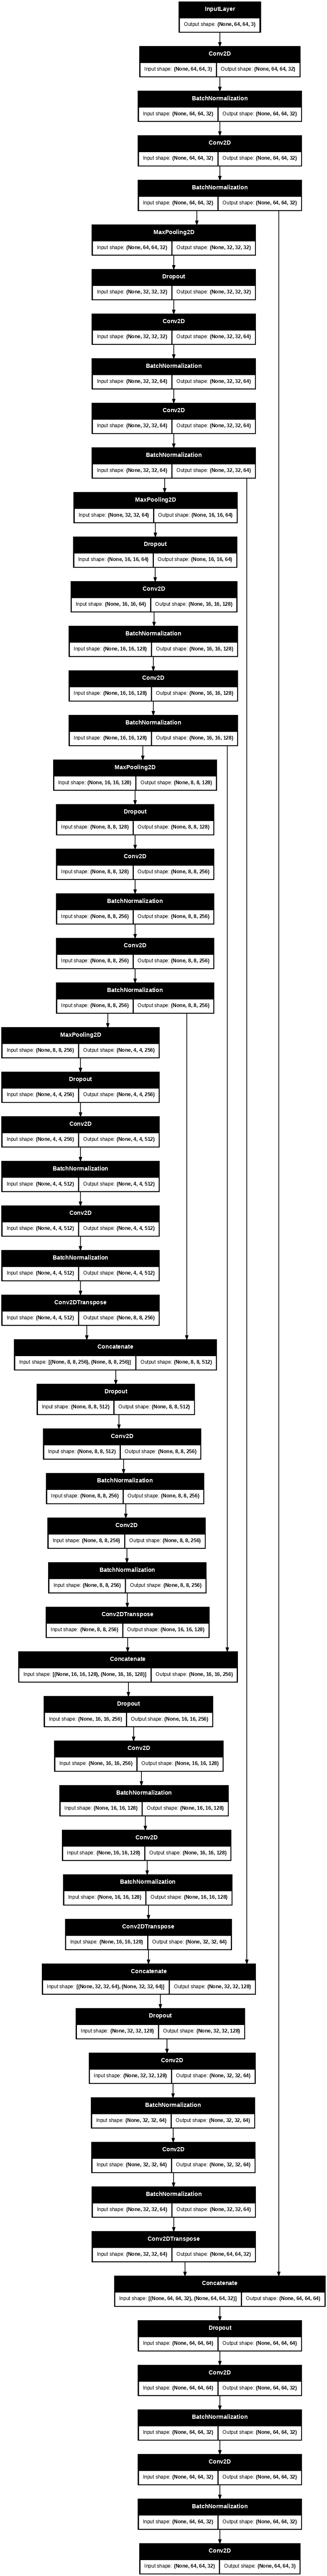

In [26]:
output_channels = 3
model = build_unet_model(output_channels)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, dpi=64)

In [31]:
history = model.fit(train_images, train_masks, epochs=200, verbose=1, validation_data=(val_images, val_masks),callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=1,restore_best_weights=True)])

Epoch 1/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6182 - loss: 0.5808 - val_accuracy: 0.6265 - val_loss: 0.5840
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6113 - loss: 0.5804 - val_accuracy: 0.6084 - val_loss: 0.5837
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6224 - loss: 0.5800 - val_accuracy: 0.5964 - val_loss: 0.5861
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6200 - loss: 0.5797 - val_accuracy: 0.6177 - val_loss: 0.5843
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6353 - loss: 0.5793 - val_accuracy: 0.6342 - val_loss: 0.5838
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6276 - loss: 0.5797 - val_accuracy: 0.6022 - val_loss: 0.5846
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.6226 - loss: 0.5782 - val_accuracy: 0.6446 - val_loss: 0.5830
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6345 - loss: 0.5781 - val_accurac

In [32]:
def plot_history(history):
  acc  = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.show()

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.show()

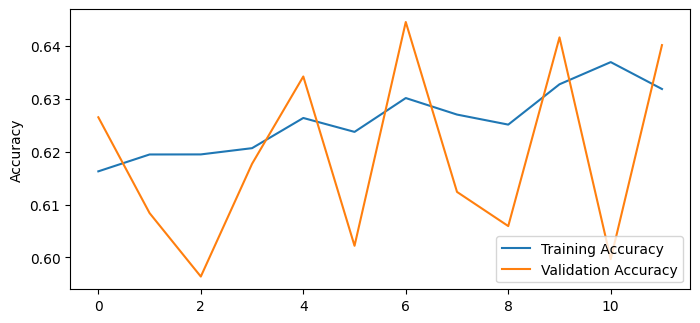

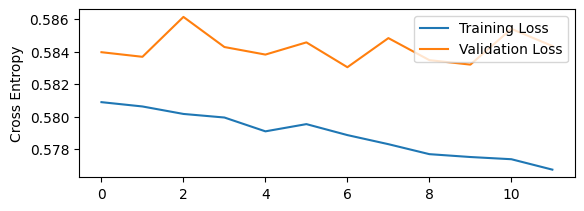

In [33]:
plot_history(history)

In [68]:
def plot_preds(val_images, val_masks):
    pred = model.predict(val_images)
    plt.figure(figsize=(8, 6))

    # İlk görüntü
    plt.subplot(3, 3, 1)
    plt.title("Input Image")
    plt.imshow(val_images[10])
    plt.axis('off')

    # Gerçek maske
    plt.subplot(3, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(val_masks[10])
    plt.axis('off')

    # Tahmin edilen maske
    plt.subplot(3, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred[10])
    plt.axis('off')

    plt.tight_layout()
    plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


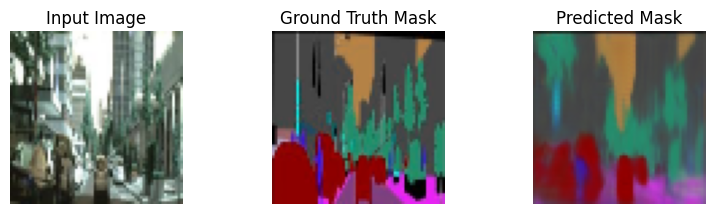

In [69]:
plot_preds(val_images,val_masks)